In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers.merge import Dot

from keras.layers.merge import Add
from keras import regularizers

Using TensorFlow backend.
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

**Resources** :

*Matrix Factorization techniques for Recommender Systems*, Koren (2009)    
https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf

Hands on Machine Learning with scikit-learn and tensorflow:             
https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf

The movieLens dataset:                                                
https://grouplens.org/datasets/movielens/ 

Keras Sequential API doc :                                            
https://keras.io/models/model/


# Recommender systems : collaborative filtering via matrix factorization

Do you wonder how Netflix is able to recommend you movies despite it doesn't know anything about you but the ratings you gave to the movies you watched ? This is what we are going to explore during this 3 days machine learning module.

First off, let's learn about what are recommender system, collaborative filtering and matrix factorization techniques, which are all very well introduced in Koren's 2009 famous article : *Matrix Factorization techniques for Recommender Systems* : https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf . Read the 4 first pages (up to section *adding biases* included). 

Through this notebook we are going to re-implement the model described in the pages you read, and apply it to a classic movie ratings dataset coming from the website *movieLens*. To do so, we will use a powerful deep learning python library called *Keras*, that makes it easy to train complex models based on linear algebra.

Install it in your python environment with the command:
```
conda install keras
```

## Load the dataset

For this module, we are going to use the movieLens dataset, that contains data from the movie recommending website movielens. The data is a subset of ratings from 0 to 5 given by some users of the website to a subset of movies. You can read more about it here (we are using the latest small dataset) : https://grouplens.org/datasets/movielens/ , and in the *README* file that is in the *data/ml-latest-small/* folder.

Load the ratings data into a datafram, and split the rows of this dataframe in a random 90%/10% train/test sets. Re-index the user and movie ids to indexes going from 0 to `nb_users` and 0 to `nb_movies` respectively (you'll see that this is not the case in the data file). Fill the `get_train_test_sets` function below to do so, and respect the returned objects structure that is described in the docstring:

In [2]:
ratings=pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.movieId.nunique()

9724

In [3]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [4]:
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [5]:
def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Returns:
        train, test, nb_users, nb_movies, user_ids_map, movie_ids_map
        Where train and test are pandas DataFrames with columns: userId,movieId,rating,timestamp
    
        nb_users and nb_movies are the number of users and ids
    
        user_ids_map and movie_ids_map are dict that map the ids in the data file
        to your own indexation of users and movies that goes from 0 to nb_users and 0 to nb_movies.
    """
  
    nb_users=ratings.userId.nunique()
    mapping_users={}
    user_ids_map={}
    for i in range(0,nb_users):
        user_ids_map[i]=ratings.userId.unique()[i]
        mapping_users[ratings.userId.unique()[i]]=i

    ratings.userId=ratings.userId.map(mapping_users)
    
    nb_movies=ratings.movieId.nunique()
    mapping_movies={}
    movie_ids_map={}
    for i in range(0,nb_movies):
        movie_ids_map[i]=ratings.movieId.unique()[i]
        mapping_movies[ratings.movieId.unique()[i]]=i

    ratings.movieId=ratings.movieId.map(mapping_movies)
    
    # Split train and test sets
    train =ratings.sample(frac=train_prop, replace=False)
    n=int(len(ratings)*round((1-train_prop), 1))
    test=ratings.drop(train.index).sample(n,replace=False)
    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map

In [6]:
ratings_s_path =  '../data/ml-latest-small/ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

Let's have a quick look at the ratings distribution:

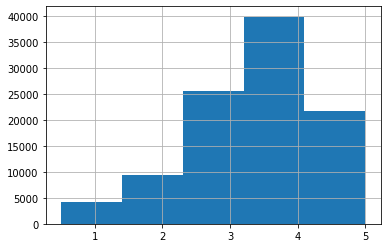

In [7]:
dataset['rating'].hist(bins=5)

## Matrix Factorization with Keras

Keras is a python library made for easily designing complex models such as deep learning models, in this module we are going to use just a few features from it to implement our simple matrix factorization model, as it makes a good introduction to the library before the next module about deep learning where you will also be using Keras.

The following function `get_mf_model` implements the model described in equation (2) in Koren's paper (without the $+\lambda(\ldots)$ part for the moment). So it basically tries to find the $p_u \in \mathbb{R}^k$ and $q_i \in \mathbb{R}^k$ vectors that minimizes the squared loss between their dot product $p_u^Tq_i$, and the observed ratings $r_{ui}$, from random initialization of $p_u$ and $q_i$. In machine learning terms, $p_u$ and $q_i$ are called the *embeddings* of the user $u$ and of the movie $i$ respectively. Their size $k$ is an hyper-parameter of the model, which is called the *rank* of the factorization.

To do so, it uses the functional API from Keras (the other API proposed is the sequential one, but is not adapted for this model), you can read about it here : https://keras.io/getting-started/functional-api-guide/ .

Keras, unlike Numpy, uses a different progamming paradigm. Numpy uses an *imperative* programming style (like python in general), meaning that when you execute `x.dot(y)`, the dot product is actually calculated. Keras however, uses a *declarative* (also called *symbolic*) programming style, meaning that when you write `Dot()([x, y])`, you tell Keras than when you will call the *fit* function of your model in the future, you will want to do a dot product between the future values that *x* and *y* will have. And this is what Keras is about, it allows you to build your own model as a sequence of operations, describing each input and output, and then later fit it and predict with it.

Let's not get in too many details, but retain that the `get_mf_model` function below is not actually executing the model, it creates it, and returns an object of the class `keras.models.Model` that has been instructed with your model operations, and this object can then be trained with the classic `fit` and `predict` functions. 

Read carefully the comments in the code of the function to understand the different steps in the model creation process:

In [8]:
def get_mf_model(nb_users, nb_movies, k):
    """
    Takes as input the number of user, the number of movies, and the size of the embeddings k.
    """
    dim_embedddings = k
    
    #Inputs:
    #First we describe the input of the model, that is the training data that we will give it as X
    #In our case, the input are just the user index u and the movie index i.
    #So we declare two inputs of size one:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    #Then let's declare our variable, the embeddings p and q.
    #First with the users, we declare that we have nb_users embeddings, each of size dim_embeddings.
    #An embedding object is indexed by calling it with the index parameter like a function,
    #so we add a `(u)` at the end to tell keras we want it to be indexed 
    #by the user ids we will pass at training time as inputs.
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    
    #Unfortunatly, when indexing an embeddings it keeps [1,k] matrix shape instead
    #of just a [k] vector, so we have to tell Keras that we just want a vector by
    #redefining its shape:
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Same thing for the movie embeddings:
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    #Then the dot product between the two indexed embeddings, 
    #we'll understand the axes = 1 part later.
    r_hat = Dot(axes = 1)([q_i, p_u])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model

In [9]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

Instructions for updating:
Colocations handled automatically by placer.


Keras allows us to have a textual overview of the model we defined with the *summary()* function:

In [10]:
mf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i__movie_id (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
u__user_id (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
____________________________________________________________________________________________

Each of the keras objects we defined in our model is called a *layer*, and we find them in order in the first column. The *Param #* column gives the number of trainable parameters of the layer, in our case these are just the embeddings, and they should be equal to $nb\_users \times k$ and $nb\_movies \times k$. The *Connected to* column tells for each layer which layers are inputs for this layer (you can safely ignore the `[0][0]` for this module).

Finally the *Output Shape* column gives us the shape of the layer, each layer being a *tensor*. A tensor is the geeralization of matrices to more than two dimensions. So a matrix is a 2D-tensor and a vector is a 1D-tensor, and each layer can be a matrix, a vector, or a higher order tensor. The output shape we see is indeed the expected one at each layer, except there is this `None` in first dimension, why is that ?

To understand it, we have to get into how Keras is actually minimizing the mean squared loss of our model. In general, when in comes to minimizing error functions on big datasets, a generic method is to use Stocastic Gradient Descent (SGD), briefly described in page 4 of Koren's article. 

Read about gradient descent, SGD and its variant mini-batch SGD in Chapter 4 of *Hands on ML ...* (pages 111-120):
https://www.lpsm.paris/pageperso/has/source/Hand-on-ML.pdf

This is what Keras does when it fits the model, it initializes the $q_i$ and $p_u$ embedding vectors randomly, and then perform mini-batch SGD to find the minimum mean squared error on the training set. Since mini-batching means considering multiple training samples at the same time, Keras keeps the first dimension of each layer to stack the samples of each batch, this is why `None` is written, the actual batch_size being set at training time when calling the `fit` function. This is also why we had to set `axes=1` when calling the `Dot` layer in the `get_mf_model` function, because the first dimension (axe 0) of each layer is kept for the batches. And about the `optimizer='adam'`, it is just a variation of mini-batch SGD that is faster, we'll get into more details about SGD variations in the optional parts of this notebook.

Let's finally train our matrix factorization model on our movieLens data. The `nb_epoch` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 10 for the moment:

In [11]:
history = mf_model.fit(X_train, y_train, nb_epoch=10, batch_size=32)


Instructions for updating:
Use tf.cast instead.


/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
90752/90752 [==============================] - 9s 104us/step - loss: 8.7121 - mse: 8.7121
Epoch 2/10
90752/90752 [==============================] - 9s 103us/step - loss: 1.9434 - mse: 1.9434
Epoch 3/10
90752/90752 [==============================] - 9s 100us/step - loss: 1.1638 - mse: 1.1638
Epoch 4/10
90752/90752 [==============================] - 8s 93us/step - loss: 0.9151 - mse: 0.9151
Epoch 5/10
90752/90752 [==============================] - 8s 87us/step - loss: 0.7851 - mse: 0.7851
Epoch 6/10
90752/90752 [==============================] - 8s 89us/step - loss: 0.6937 - mse: 0.6937
Epoch 7/10
90752/90752 [==============================] - 9s 98us/step - loss: 0.6199 - mse: 0.6199
Epoch 8/10
90752/90752 [==============================] - 10s 111us/step - loss: 0.5591 - mse: 0.5591
Epoch 9/10
90752/90752 [==============================] - 9s 102us/step - loss: 0.5085 - mse: 0.5085
Epoch 10/10
90752/90752 [==============================] - 10s 109us/step - loss: 0.4635 - mse

And we can now try to predict the test ratings, and report our root mean squared error like in other regression problems:

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0847022979172942 


You should get about 1.1/1.2 RMSE, not that bad without any information about the users nor the movies ! This is the power of collaborative filtering models.

## Train the same model on your GPU and on your CPU, and compare the training time

Keras uses the `tensorflow` python library for the computation part, if you have installed your GPU drivers and the GPU version of tensorflow, then it will run on your GPU by default. To get an idea of the computation speed-up given by GPUs, let's force keras to use the cpu instead:

In [13]:
# import tensorflow as tf

# with tf.device('/cpu:0'):
#     mf_model = get_mf_model(nb_users, nb_movies, k)
#     history = mf_model.fit(X_train, y_train, nb_epoch=10, batch_size=32)

## Adding user and movie bias

Let's enhance our matrix factorization model and add the user and movie biases to the rating estimation function as in equation (4) of Koren's paper ; except we will for the moment forget about the global bias $\mu$ as it is not so intuitive to implement in Keras. Fill the function below to do so:

In [14]:
def get_mf_bias_model(nb_users, nb_movies, k):
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = -1)([p_u, q_i])
    
    # Bias: average of all ratings, plus user bias plus movie bias
    p_u_bias = Embedding(nb_users, 1, name="p_u__user_bias")(u)
    p_u_bias = Reshape((1,), name="p_u__user_bias_reshaped")(p_u_bias)
    
    q_i_bias = Embedding(nb_movies, 1, name="q_i__movie_bias")(i)
    q_i_bias = Reshape((1,), name="q_i__movie_bias_reshaped")(q_i_bias)
    
    r_hat_added = Add()([d,p_u_bias,q_i_bias])
    
    
    model = Model(inputs=[u, i], outputs=r_hat_added)
    # Defining the loss, optimizer and metrics to use
    
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [15]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [16]:
mf_bias_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
____________________________________________________________________________________________

In [17]:
history = mf_bias_model.fit(X_train, y_train, nb_epoch=10, batch_size=32)


/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
90752/90752 [==============================] - 8s 91us/step - loss: 7.0864 - mse: 7.0864
Epoch 2/10
90752/90752 [==============================] - 8s 88us/step - loss: 1.3954 - mse: 1.3954
Epoch 3/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.9094 - mse: 0.9094
Epoch 4/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.7669 - mse: 0.7669
Epoch 5/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.6837 - mse: 0.6837
Epoch 6/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.6156 - mse: 0.6156
Epoch 7/10
90752/90752 [==============================] - 8s 89us/step - loss: 0.5551 - mse: 0.5551
Epoch 8/10
90752/90752 [==============================] - 9s 99us/step - loss: 0.4978 - mse: 0.4978
Epoch 9/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.4440 - mse: 0.4440
Epoch 10/10
90752/90752 [==============================] - 8s 88us/step - loss: 0.3936 - mse: 0.3936

In [18]:
y_pred = mf_bias_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 0.9512532244659844 


You should get a lower RMSE, about 0.9/1.0

## Adding L2 regularization

For the moment we have omitted the regularization of the embeddings and bias parameters, as described in equation (5) of Koren's paper. We are now going to add them to the model, have a look at https://keras.io/layers/embeddings/ and https://keras.io/regularizers/ to see how to do this with keras. Fill the function below to implement it:

In [19]:
def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, l2_reg):
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = -1)([p_u, q_i])
    
    # Bias: average of all ratings, plus user bias plus movie bias
    p_u_bias = Embedding(nb_users, 1, name="p_u__user_bias",embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u_bias = Reshape((1,), name="p_u__user_bias_reshaped")(p_u_bias)
    
    q_i_bias = Embedding(nb_movies, 1, name="q_i__movie_bias",embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i_bias = Reshape((1,), name="q_i__movie_bias_reshaped")(q_i_bias)
    
    r_hat_added = Add()([d,p_u_bias,q_i_bias])
    
    
    model = Model(inputs=[u, i], outputs=r_hat_added)
    # Defining the loss, optimizer and metrics to use
    
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model

In [20]:
l2_reg = 0.00005
mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, l2_reg)

In [21]:
mf_bias_reg_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
____________________________________________________________________________________________

In [22]:
history = mf_bias_reg_model.fit(X_train, y_train, nb_epoch=10, batch_size=32)


/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
90752/90752 [==============================] - 13s 141us/step - loss: 6.8921 - mse: 6.7924
Epoch 2/10
90752/90752 [==============================] - 14s 159us/step - loss: 1.7815 - mse: 1.4694
Epoch 3/10
90752/90752 [==============================] - 14s 153us/step - loss: 1.3832 - mse: 0.9948
Epoch 4/10
90752/90752 [==============================] - 13s 138us/step - loss: 1.2703 - mse: 0.8611
Epoch 5/10
90752/90752 [==============================] - 13s 143us/step - loss: 1.2050 - mse: 0.7944
Epoch 6/10
90752/90752 [==============================] - 14s 156us/step - loss: 1.1551 - mse: 0.7490
Epoch 7/10
90752/90752 [==============================] - 13s 142us/step - loss: 1.1135 - mse: 0.7120
Epoch 8/10
90752/90752 [==============================] - 13s 138us/step - loss: 1.0740 - mse: 0.6754
Epoch 9/10
90752/90752 [==============================] - 16s 171us/step - loss: 1.0392 - mse: 0.6430
Epoch 10/10
90752/90752 [==============================] - 16s 177us/step - loss: 

In [23]:
history

In [24]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 0.9306723841221494 


You should get a slightly better RMSE, but sometimes regularization is very important for achiebing good test performances, in depends on the data.

## Grid search embedding size and regularization factor

So for the moment we didn't grid search our model hyper-parameters, such as `k` and `l2_reg`. There exists some scikit-learn wrappers for keras models in order to use scikit grid search functions, unfortunately they only work with single input keras models, which is not our case as we have two inputs: the user and the movie indexes.

So let's implement your own grid search function for the two parameters `k` and `l2_reg`. With big enough datasets, it is not necessary to do a cross-validation for each hyper-parameter combination, and we can simply split the training set into a sub-training set and a validation set to test our hyper-parameters. It does work because the validation set is big enough to see enough data variations, and with very big datasets, it is anyway not possible anymore to do a full cross-validation as it takes too much time to train. 

Fill in the `grid_search` function below that splits the training set 90%/10%, train and test all the hyper-parameter combinations from the `param_grid` parameter, with the model returned by the `get_model_function` (yes, you can pass functions as parameters!), and returns the hyper-parameters that give the lowest RMSE on the 10% validation set.

In [25]:
import itertools
from sklearn.model_selection import train_test_split


def grid_search(train, param_grid, get_model_function, nb_users, nb_movies, validation_size=0.1):
    
    validation = train.sample(frac=validation_size, replace=False)
    
    train_GS=train.drop(validation.index)
    
    
    X_validation = [validation["userId"].to_numpy(), validation["movieId"].to_numpy()]
    y_validation = validation["rating"].to_numpy()

    X_train_GS = [train_GS["userId"].to_numpy(), train_GS["movieId"].to_numpy()]
    y_train_GS = train_GS["rating"].to_numpy()
    
    results=pd.DataFrame(columns=['Tryout','k','l2','RMSE'])
    i=0
    
    for k in param_grid['k']:
        for l2 in param_grid['l2_reg']:  
            model=get_model_function(nb_users, nb_movies, k, l2)
            model.fit(X_train_GS, y_train_GS, nb_epoch=10, batch_size=32)
            y_pred = model.predict(X_validation)
            test_rmse = sqrt(mean_squared_error(y_validation, y_pred))
            results.loc[i]=[i]+[k]+[l2]+[test_rmse]
            i+=1  
            
    return results

In [26]:
l2_reg = [0.0001, 0.00005, 0.00001]
k = [15,30]

param_grid = dict(k=k, l2_reg=l2_reg)

results = grid_search(train, param_grid, get_mf_bias_l2_reg_model,
                                      nb_users, nb_movies)

results

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 11s 136us/step - loss: 7.8976 - mse: 7.7750
Epoch 2/10
81677/81677 [==============================] - 9s 111us/step - loss: 2.4450 - mse: 2.0008
Epoch 3/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.8302 - mse: 1.2467
Epoch 4/10
81677/81677 [==============================] - 9s 108us/step - loss: 1.6687 - mse: 1.0375
Epoch 5/10
81677/81677 [==============================] - 9s 108us/step - loss: 1.5947 - mse: 0.9585
Epoch 6/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.5426 - mse: 0.9183
Epoch 7/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.5009 - mse: 0.8919
Epoch 8/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.4651 - mse: 0.8708
Epoch 9/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.4322 - mse: 0.8503
Epoch 10/10
81677/81677 [==============================] - 9s 109us/step - loss: 1.4020 - 

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 9s 109us/step - loss: 7.9831 - mse: 7.9258
Epoch 2/10
81677/81677 [==============================] - 9s 106us/step - loss: 2.2030 - mse: 1.9758
Epoch 3/10
81677/81677 [==============================] - 9s 106us/step - loss: 1.4847 - mse: 1.1707
Epoch 4/10
81677/81677 [==============================] - 10s 123us/step - loss: 1.2972 - mse: 0.9401
Epoch 5/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.2183 - mse: 0.8433
Epoch 6/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.1725 - mse: 0.7920
Epoch 7/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.1360 - mse: 0.7568
Epoch 8/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.1039 - mse: 0.7269
Epoch 9/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.0755 - mse: 0.7012
Epoch 10/10
81677/81677 [==============================] - 9s 111us/step - loss: 1.0499 - 

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 10s 117us/step - loss: 8.0365 - mse: 8.0251
Epoch 2/10
81677/81677 [==============================] - 9s 112us/step - loss: 1.9446 - mse: 1.8968
Epoch 3/10
81677/81677 [==============================] - 9s 112us/step - loss: 1.1438 - mse: 1.0750
Epoch 4/10
81677/81677 [==============================] - 9s 112us/step - loss: 0.9258 - mse: 0.8442
Epoch 5/10
81677/81677 [==============================] - 9s 111us/step - loss: 0.8366 - mse: 0.7473
Epoch 6/10
81677/81677 [==============================] - 9s 112us/step - loss: 0.7860 - mse: 0.6920
Epoch 7/10
81677/81677 [==============================] - 9s 111us/step - loss: 0.7503 - mse: 0.6533
Epoch 8/10
81677/81677 [==============================] - 9s 111us/step - loss: 0.7221 - mse: 0.6230
Epoch 9/10
81677/81677 [==============================] - 9s 111us/step - loss: 0.6956 - mse: 0.5948
Epoch 10/10
81677/81677 [==============================] - 9s 111us/step - loss: 0.6713 - 

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 12s 152us/step - loss: 7.2263 - mse: 7.0464
Epoch 2/10
81677/81677 [==============================] - 12s 148us/step - loss: 2.2332 - mse: 1.6784
Epoch 3/10
81677/81677 [==============================] - 12s 147us/step - loss: 1.8152 - mse: 1.1406
Epoch 4/10
81677/81677 [==============================] - 12s 147us/step - loss: 1.6905 - mse: 0.9955
Epoch 5/10
81677/81677 [==============================] - 14s 176us/step - loss: 1.6135 - mse: 0.9301
Epoch 6/10
81677/81677 [==============================] - 13s 156us/step - loss: 1.5509 - mse: 0.8889
Epoch 7/10
81677/81677 [==============================] - 13s 156us/step - loss: 1.4966 - mse: 0.8529
Epoch 8/10
81677/81677 [==============================] - 13s 157us/step - loss: 1.4513 - mse: 0.8210
Epoch 9/10
81677/81677 [==============================] - 13s 157us/step - loss: 1.4112 - mse: 0.7925
Epoch 10/10
81677/81677 [==============================] - 15s 180us/step - loss: 

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 14s 167us/step - loss: 7.2156 - mse: 7.1244
Epoch 2/10
81677/81677 [==============================] - 13s 157us/step - loss: 1.8880 - mse: 1.5897
Epoch 3/10
81677/81677 [==============================] - 13s 157us/step - loss: 1.4339 - mse: 1.0532
Epoch 4/10
81677/81677 [==============================] - 13s 160us/step - loss: 1.3193 - mse: 0.9095
Epoch 5/10
81677/81677 [==============================] - 13s 158us/step - loss: 1.2617 - mse: 0.8485
Epoch 6/10
81677/81677 [==============================] - 13s 157us/step - loss: 1.2146 - mse: 0.8064
Epoch 7/10
81677/81677 [==============================] - 13s 158us/step - loss: 1.1678 - mse: 0.7644
Epoch 8/10
81677/81677 [==============================] - 13s 158us/step - loss: 1.1206 - mse: 0.7203
Epoch 9/10
81677/81677 [==============================] - 14s 170us/step - loss: 1.0772 - mse: 0.6787
Epoch 10/10
81677/81677 [==============================] - 13s 155us/step - loss: 

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/10
81677/81677 [==============================] - 13s 155us/step - loss: 7.3217 - mse: 7.3042
Epoch 2/10
81677/81677 [==============================] - 12s 151us/step - loss: 1.5891 - mse: 1.5262
Epoch 3/10
81677/81677 [==============================] - 12s 151us/step - loss: 1.0449 - mse: 0.9593
Epoch 4/10
81677/81677 [==============================] - 12s 151us/step - loss: 0.8935 - mse: 0.7955
Epoch 5/10
81677/81677 [==============================] - 12s 151us/step - loss: 0.8157 - mse: 0.7108
Epoch 6/10
81677/81677 [==============================] - 12s 151us/step - loss: 0.7587 - mse: 0.6496
Epoch 7/10
81677/81677 [==============================] - 12s 150us/step - loss: 0.7099 - mse: 0.5977
Epoch 8/10
81677/81677 [==============================] - 12s 151us/step - loss: 0.6654 - mse: 0.5513
Epoch 9/10
81677/81677 [==============================] - 12s 151us/step - loss: 0.6227 - mse: 0.5068
Epoch 10/10
81677/81677 [==============================] - 12s 152us/step - loss: 

,Tryout,k,l2,RMSE
0,0.0,15.0,0.00010,0.999339
1,1.0,15.0,0.00005,0.976694
2,2.0,15.0,0.00001,0.959570
3,3.0,30.0,0.00010,0.992920
4,4.0,30.0,0.00005,0.979386
5,5.0,30.0,0.00001,0.989911


## Recommend the top-5 movies for the 10 first users

Retrain your model on all the dataset with the best parameters you just found, and then compute the predictions for all the ratings that are not in the `dataset` for the 10 first users (indexes from 0 to 9). That means all the movies $i$ that these users $u \in 0,\ldots,9$ haven't rated, thus all the $u,i$ combinations that are not in the `dataset` dataframe rows.

Order these predicted ratings for these users by decreasing order, and print out the 5 first ones, i.e. the ones that have the highest predicted ratings. Use the *movies.csv* file to print the real titles.

In [72]:
def get_top_movies_for_user(model, user_id, dataset,nb_movies=5):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    """
    
    movies_not_seen = np.setxor1d(np.array(dataset.movieId.unique()),np.array(dataset[dataset.userId==user_id].movieId))
    user_id=np.full(len(movies_not_seen), user_id)
           
    pred = model.predict([user_id,movies_not_seen])
    top_indices = np.argsort(pred,axis=0)[-nb_movies:]
    best_ratings = pred[top_indices]
    best_movie_ids = movies_not_seen[top_indices]
    
#     return pred
    return best_movie_ids, best_ratings

### Fitting model

In [28]:
from keras.callbacks import EarlyStopping

X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

model=get_mf_bias_l2_reg_model(nb_users, nb_movies, 15, 2*10**-4)
model.fit(X, y, nb_epoch=500, batch_size=512,validation_split=0.1,
          callbacks=[EarlyStopping(monitor='mse', patience=10, verbose=1)])

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 90751 samples, validate on 10084 samples
Epoch 1/500
90751/90751 [==============================] - 1s 15us/step - loss: 12.6614 - mse: 12.6525 - val_loss: 11.9087 - val_mse: 11.8975
Epoch 2/500
90751/90751 [==============================] - 1s 9us/step - loss: 10.5539 - mse: 10.4894 - val_loss: 8.5496 - val_mse: 8.3828
Epoch 3/500
90751/90751 [==============================] - 1s 9us/step - loss: 6.4628 - mse: 6.1270 - val_loss: 4.8170 - val_mse: 4.3029
Epoch 4/500
90751/90751 [==============================] - 1s 9us/step - loss: 3.9647 - mse: 3.3033 - val_loss: 3.5675 - val_mse: 2.7789
Epoch 5/500
90751/90751 [==============================] - 1s 9us/step - loss: 3.1972 - mse: 2.3216 - val_loss: 3.1730 - val_mse: 2.2217
Epoch 6/500
90751/90751 [==============================] - 1s 10us/step - loss: 2.8971 - mse: 1.8910 - val_loss: 2.9876 - val_mse: 1.9314
Epoch 7/500
90751/90751 [==============================] - 1s 9us/step - loss: 2.7393 - mse: 1.6454 - val_loss: 2.8804 -

90751/90751 [==============================] - 1s 9us/step - loss: 1.7360 - mse: 0.8282 - val_loss: 1.8562 - val_mse: 0.9493
Epoch 61/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7321 - mse: 0.8251 - val_loss: 1.8531 - val_mse: 0.9464
Epoch 62/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7284 - mse: 0.8222 - val_loss: 1.8502 - val_mse: 0.9443
Epoch 63/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7249 - mse: 0.8191 - val_loss: 1.8474 - val_mse: 0.9418
Epoch 64/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7216 - mse: 0.8161 - val_loss: 1.8443 - val_mse: 0.9389
Epoch 65/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7184 - mse: 0.8127 - val_loss: 1.8421 - val_mse: 0.9375
Epoch 66/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.7155 - mse: 0.8104 - val_loss: 1.8403 - val_mse: 0.9359
Epoch 67/500
90751/90751 [=====================

Epoch 178/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6591 - mse: 0.7085 - val_loss: 1.8400 - val_mse: 0.8892
Epoch 179/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6592 - mse: 0.7080 - val_loss: 1.8401 - val_mse: 0.8890
Epoch 180/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6591 - mse: 0.7079 - val_loss: 1.8401 - val_mse: 0.8890
Epoch 181/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6592 - mse: 0.7075 - val_loss: 1.8403 - val_mse: 0.8889
Epoch 182/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6591 - mse: 0.7074 - val_loss: 1.8402 - val_mse: 0.8888
Epoch 183/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6591 - mse: 0.7075 - val_loss: 1.8406 - val_mse: 0.8888
Epoch 184/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6591 - mse: 0.7072 - val_loss: 1.8408 - val_mse: 0.8891
Epoch 185/500
90751/90751 [

Epoch 237/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6584 - mse: 0.7014 - val_loss: 1.8450 - val_mse: 0.8878
Epoch 238/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6583 - mse: 0.7011 - val_loss: 1.8452 - val_mse: 0.8880
Epoch 239/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6584 - mse: 0.7008 - val_loss: 1.8451 - val_mse: 0.8881
Epoch 240/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6583 - mse: 0.7007 - val_loss: 1.8450 - val_mse: 0.8880
Epoch 241/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6583 - mse: 0.7009 - val_loss: 1.8450 - val_mse: 0.8879
Epoch 242/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6583 - mse: 0.7015 - val_loss: 1.8448 - val_mse: 0.8877
Epoch 243/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6584 - mse: 0.7011 - val_loss: 1.8448 - val_mse: 0.8875
Epoch 244/500
90751/90751 [

Epoch 296/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6581 - mse: 0.6987 - val_loss: 1.8467 - val_mse: 0.8878
Epoch 297/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6582 - mse: 0.6990 - val_loss: 1.8465 - val_mse: 0.8876
Epoch 298/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6582 - mse: 0.6989 - val_loss: 1.8465 - val_mse: 0.8876
Epoch 299/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6581 - mse: 0.6991 - val_loss: 1.8465 - val_mse: 0.8876
Epoch 300/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6581 - mse: 0.6989 - val_loss: 1.8466 - val_mse: 0.8882
Epoch 301/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6581 - mse: 0.6993 - val_loss: 1.8468 - val_mse: 0.8878
Epoch 302/500
90751/90751 [==============================] - 1s 9us/step - loss: 1.6582 - mse: 0.6992 - val_loss: 1.8469 - val_mse: 0.8879
Epoch 303/500
90751/90751 [

In [29]:
five_best_movie_ids, five_best_ratings=get_top5_for_user(model,0,dataset)

In [58]:
movies=pd.read_csv('../data/ml-latest-small/movies.csv')
top_5_movies_10_users = pd.DataFrame(columns=['User','Movie','Predicted_rating'])
for user_id in range(0,10):
    five_best_movie_ids, five_best_ratings=get_top5_for_user(model,user_id,dataset)
    j,k=4,0
    for i in np.hstack(five_best_movie_ids)[::-1]:
        top_5_movies_10_users.loc[user_id*5+k]=[user_ids_map[user_id]]+[movies.loc[movies.movieId==movie_ids_map[i]].title.values[0]]+[float(five_best_ratings[j])]
        j-=1
        k+=1

In [59]:
top_5_movies_10_users

,User,Movie,Predicted_rating
0,1,"Shawshank Redemption, The (1994)",5.165443
1,1,"Godfather, The (1972)",5.060540
2,1,"Lord of the Rings: The Return of the King, The...",5.026017
3,1,One Flew Over the Cuckoo's Nest (1975),5.024269
4,1,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",5.015644
5,2,Pulp Fiction (1994),3.757599
6,2,"Matrix, The (1999)",3.726705
7,2,Fight Club (1999),3.702254
8,2,Forrest Gump (1994),3.696409
9,2,"Usual Suspects, The (1995)",3.695276


## Visualize the embeddings

Let's now have a look at what is going on in the embedding space of the movies that we learnt. Our brain cannot picture anything beyond 3 dimensions, and we learnt high dimensional embeddings (k=15 or 30), so we are going to project the movies embeddings on a 2D plane, first with PCA, and then with another algorithm made for visualizing high dimensional spaces called t-sne.

### PCA

You have already studied PCA, it is a useful technique for dimensionality reduction, but also simply for visualization. Don't forget to scale your embeddings first. To access the embeddings values of your keras model, have a look at the *get_weights()* function.

Compute a PCA on all your movies embeddings, get the 2 first principal components, and do a scatter plot of 20 randomly sampled movies on a 2D plane, where each movie is a point defined by the two values of the two first principal components of the PCA from its embedding. Add the titles to the plot, and try to see if you can interpret the axes of the PCA through to different movie genres, like in Figure 3 from the article *Matrix Factorization Techniques for Recommender Systems*.

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

p_w = model.get_weights()[0]
std = StandardScaler()
p_w_s = std.fit_transform(p_w)

q_w = model.get_weights()[1]
std = StandardScaler()
q_w_s = std.fit_transform(q_w)


p_b_w = model.get_weights()[2]
q_b_w = model.get_weights()[3]

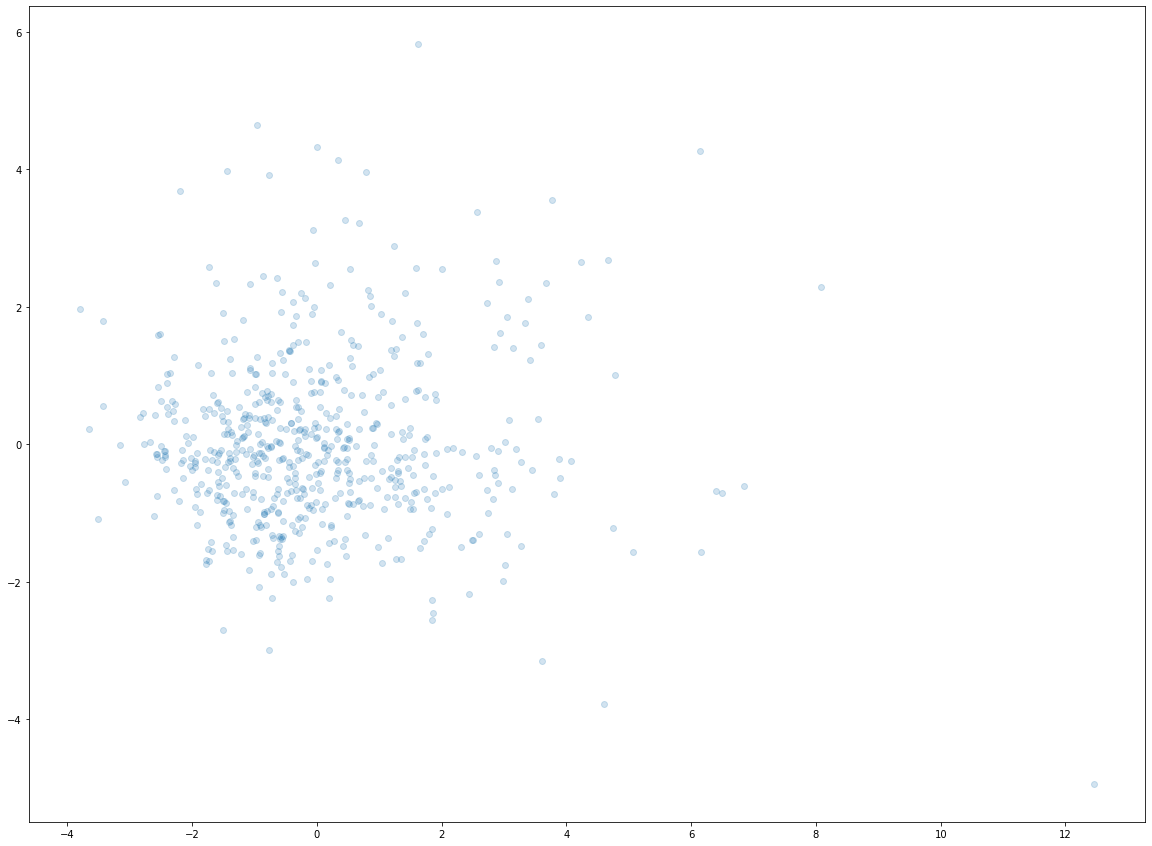

In [132]:
# PCA analysis of users
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(p_w_s)


rcParams['figure.figsize'] = 20, 15

pc1,pc2 = zip(*principalComponents)
plt.scatter(pc1,pc2, alpha=0.2)
plt.show()

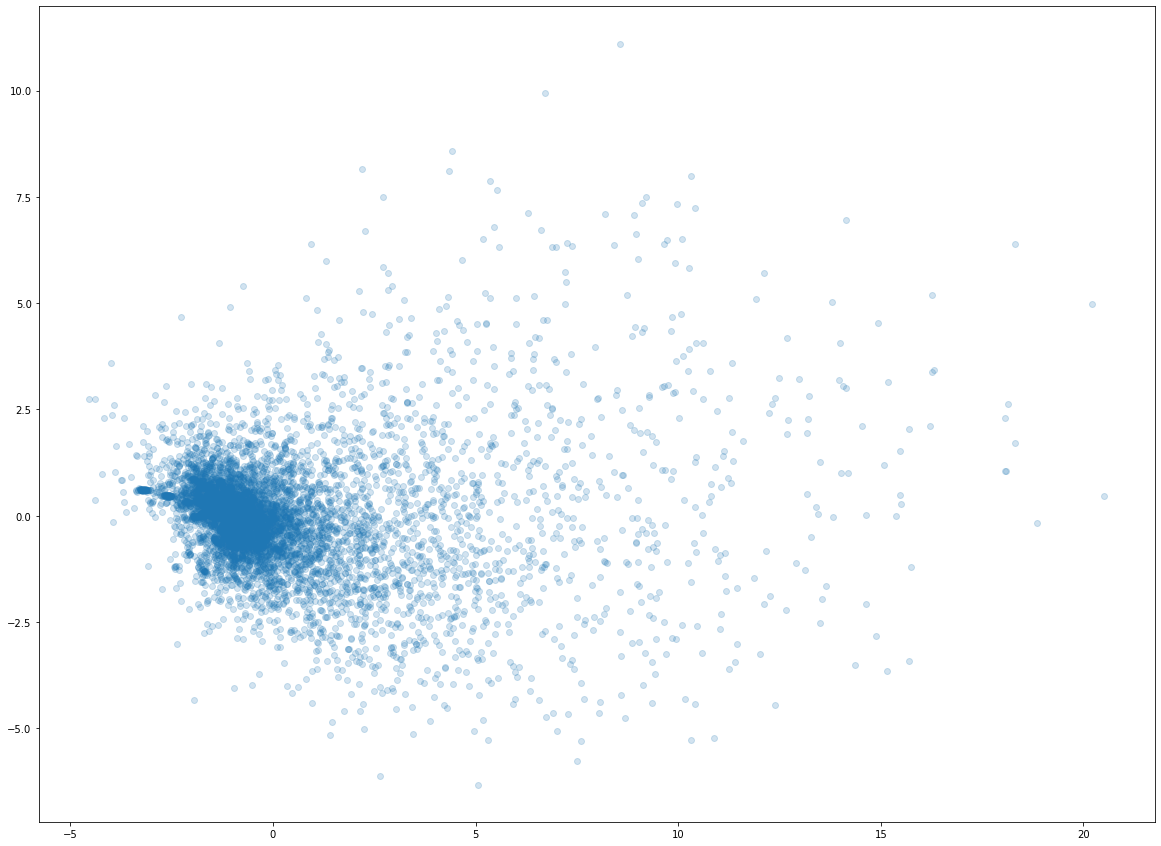

In [133]:
# PCA analysis of movies
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(q_w_s)


rcParams['figure.figsize'] = 20, 15

pc1,pc2 = zip(*principalComponents)
plt.scatter(pc1,pc2, alpha=0.2)
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


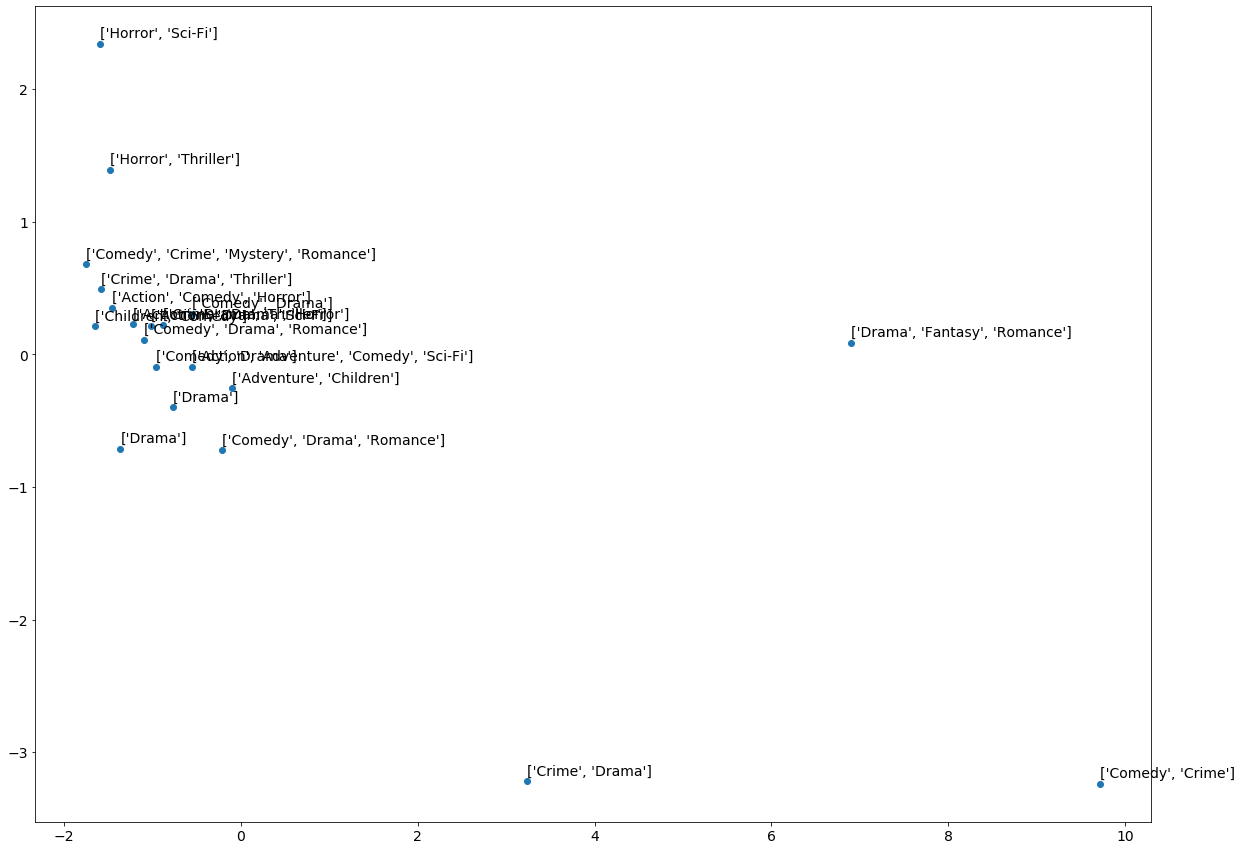

In [134]:
random_indices = np.random.randint(0,principalComponents.shape[0]+1,20)

font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

n=[]
for i in random_indices:
    n.append(movies.loc[movies.movieId==movie_ids_map[i]].genres.values[0])

pc1,pc2 = zip(*principalComponents[random_indices])
plt.scatter(pc1,pc2)

for i, txt in enumerate(n):
    plt.annotate(txt, (pc1[i], pc2[i]),xytext=(pc1[i],pc2[i]+0.05))
plt.show()

## t-sne

Let's do the same with t-sne, an algorithm specialized for visualizing high dimensional spaces, you can read more about it there : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [ ]:
from sklearn.manifold import TSNE

tsne_components = TSNE(n_components=2).fit_transform(q_w_s)



In [ ]:
random_indices = np.random.randint(0,tsne_components.shape[0]+1,20)

n=[]
for i in random_indices:
    n.append(movies.loc[movies.movieId==movie_ids_map[i]].genres.values[0])

ts1,ts2 = zip(*tsne_components[random_indices])
plt.scatter(ts1,ts2)

for i, txt in enumerate(n):
    plt.annotate(txt, (ts1[i], ts2[i]),xytext=(ts1[i],ts2[i]+2))
plt.show()

T-sne in general tends to preserve local similarities better than PCA. In any case, it's always interesting to try both for visualizing high dimensional data.

## Defininig own user

In [212]:
import random
def rate_my_movies(my_user_id, dataset, nb_movies, nb_to_rate, movie_ids_map):
    inverse_movie_ids_map = {v: k for k, v in movie_ids_map.items()}
    movies_info = pd.read_csv('../data/ml-latest-small/movies.csv')
    ml_movie_id_to_title = dict(zip(movies_info['movieId'], movies_info['title']))
    my_ratings = pd.DataFrame(columns = dataset.columns)
    rated = 0
    print("Rate " + str(nb_to_rate) + " movies between 0 and 5, type enter to pass:")
    while rated < nb_to_rate:
        movie_id_to_rate = random.randint(0,nb_movies)
        print(ml_movie_id_to_title[ movie_ids_map[ movie_id_to_rate ] ])
        c = None
        while c not in ['','0','1','2','3','4','5']:
            if c is not None:
                print("Incorrect value, type a rating value between 0 and 5, or 'enter' to pass")
            c = input()
        if c != '':
            my_ratings.loc[rated] = [my_user_id,movie_id_to_rate, int(c), 0]
            rated += 1
    return my_ratings


my_user_id = len(user_ids_map)
nb_users = len(user_ids_map) + 1
my_ratings = rate_my_movies(my_user_id, dataset, nb_movies, 40, movie_ids_map)
dataset_with_me = pd.concat([dataset, my_ratings], axis = 0).sample(frac=1).reset_index(drop=True)
X_with_me = [dataset_with_me["userId"].to_numpy(), dataset_with_me["movieId"].to_numpy()]
y_with_me = dataset_with_me["rating"].to_numpy()

Rate 40 movies between 0 and 5, type enter to pass:
Leaving Las Vegas (1995)

Goat (2016)

Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
5
Wow! A Talking Fish! (1983)

We're No Angels (1989)

Drowning Mona (2000)

8 Women (2002)

Endless Poetry (2016)

About Time (2013)

Bulletproof (1996)

Broken (2012)

Major and the Minor, The (1942)

Ghoulies II (1987)

Walking and Talking (1996)

TiMER (2009)

Lifted (2006)

Poetic Justice (1993)

Shaolin Temple (Shao Lin si) (1976)

Crush (2001)

I Heart Huckabees (2004)

Book of Love (1990)

Where the Heart Is (2000)

Sex, Lies, and Videotape (1989)

Star Wars: Episode III - Revenge of the Sith (2005)
2
November (2004)

Alone in the Dark II (2008)

Dummy (2002)

Hustler, The (1961)

Red Lights (Feux rouges) (2004)

Exterminating Angel, The (Ángel exterminador, El) (1962)

Tucker & Dale vs Evil (2010)

Great Gatsby, The (2013)

With Six You Get Eggroll (1968)

Queen Margot (Reine Margot, La) (1994)

Zulu (2013)

Peter'

KeyError: 9724

In [153]:
model=get_mf_bias_l2_reg_model(nb_users, nb_movies, 15, 2*10**-4)
model.fit(X_with_me, y_with_me, nb_epoch=500, batch_size=512,validation_split=0.1,
          callbacks=[EarlyStopping(monitor='mse', patience=10, verbose=1)])

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 90769 samples, validate on 10086 samples
Epoch 1/500
90769/90769 [==============================] - 2s 17us/step - loss: 12.6747 - mse: 12.6655 - val_loss: 11.9570 - val_mse: 11.9445
Epoch 2/500
90769/90769 [==============================] - 1s 11us/step - loss: 10.5404 - mse: 10.4742 - val_loss: 8.6189 - val_mse: 8.4530
Epoch 3/500
90769/90769 [==============================] - 1s 11us/step - loss: 6.5285 - mse: 6.1981 - val_loss: 4.8947 - val_mse: 4.3885
Epoch 4/500
90769/90769 [==============================] - 1s 11us/step - loss: 4.0021 - mse: 3.3474 - val_loss: 3.5958 - val_mse: 2.8120
Epoch 5/500
90769/90769 [==============================] - 1s 11us/step - loss: 3.2113 - mse: 2.3395 - val_loss: 3.1864 - val_mse: 2.2381
Epoch 6/500
90769/90769 [==============================] - 1s 11us/step - loss: 2.9042 - mse: 1.9000 - val_loss: 2.9933 - val_mse: 1.9392
Epoch 7/500
90769/90769 [==============================] - 1s 11us/step - loss: 2.7427 - mse: 1.6501 - val_loss: 2.8

Epoch 118/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6663 - mse: 0.7339 - val_loss: 1.8196 - val_mse: 0.8873
Epoch 119/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6660 - mse: 0.7331 - val_loss: 1.8197 - val_mse: 0.8866
Epoch 120/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6658 - mse: 0.7325 - val_loss: 1.8203 - val_mse: 0.8867
Epoch 121/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6657 - mse: 0.7317 - val_loss: 1.8203 - val_mse: 0.8864
Epoch 122/500
90769/90769 [==============================] - 1s 11us/step - loss: 1.6655 - mse: 0.7311 - val_loss: 1.8204 - val_mse: 0.8860
Epoch 123/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6654 - mse: 0.7304 - val_loss: 1.8207 - val_mse: 0.8857
Epoch 124/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6652 - mse: 0.7300 - val_loss: 1.8209 - val_mse: 0.8857
Epoch 125/500
90769/

90769/90769 [==============================] - 1s 10us/step - loss: 1.6605 - mse: 0.7035 - val_loss: 1.8352 - val_mse: 0.8785
Epoch 235/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6605 - mse: 0.7034 - val_loss: 1.8352 - val_mse: 0.8786
Epoch 236/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6605 - mse: 0.7034 - val_loss: 1.8351 - val_mse: 0.8783
Epoch 237/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6604 - mse: 0.7034 - val_loss: 1.8353 - val_mse: 0.8784
Epoch 238/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6605 - mse: 0.7034 - val_loss: 1.8351 - val_mse: 0.8784
Epoch 239/500
90769/90769 [==============================] - 1s 10us/step - loss: 1.6605 - mse: 0.7033 - val_loss: 1.8351 - val_mse: 0.8781
Epoch 240/500
90769/90769 [==============================] - 1s 11us/step - loss: 1.6605 - mse: 0.7032 - val_loss: 1.8353 - val_mse: 0.8784
Epoch 241/500
90769/90769 [=======

In [154]:
best_movie_ids, best_ratings = get_top_movies_for_user(model, my_user_id, dataset_with_me,nb_movies=15)
my_top_15_movies = pd.DataFrame(columns=['Movie','Predicted_rating'])

j,k=14,0
for i in np.hstack(best_movie_ids)[::-1]:
    my_top_15_movies.loc[k]=[movies.loc[movies.movieId==movie_ids_map[i]].title.values[0]]+[float(best_ratings[j])]
    j-=1
    k+=1

    

In [155]:
my_top_15_movies

,Movie,Predicted_rating
0,"Shawshank Redemption, The (1994)",3.409860
1,Forrest Gump (1994),3.202649
2,Pulp Fiction (1994),3.149393
3,"Usual Suspects, The (1995)",3.140581
4,"Silence of the Lambs, The (1991)",3.135356
5,Schindler's List (1993),3.125233
6,Braveheart (1995),3.072477
7,"Matrix, The (1999)",3.047889
8,Star Wars: Episode IV - A New Hope (1977),3.023900
9,Seven (a.k.a. Se7en) (1995),3.021901


# OPTIONAL PARTS

## Reuse the movie embeddings to predict the movies genre with multi-label classification

Beyond the goal of predicting missing rating, the matrix factorization techniques also produces vectorial representation of movies and users: their embeddings, what we just visualized for the movies. With a big enough dataset, these embeddings actually are good abstract representations of the movies and of the users, and can be reused as features for other tasks, such as classification.

In the *movies.csv*, there is a column that gives the genres of each movie. Let's try to predict the genres of the movies from the embeddings we learnt. As you can see, each movie can have more than one genre, so in classification terms, more than one class. We can achieve that with *multilabel classification*. You can read more about it there: https://scikit-learn.org/stable/modules/multiclass.html

Load the movies genre, encode them as binary classes and use the classes imported below to train a multilabel classifier that uses the movie embeddings as features, and the movie genres as classes. Use the *OneVsRestClassifier* with a simple *LinearSVC* without any hyper-parameter tuning. Finally print the test accuracy, F1, precision and recall for each class, as well as the number of time each class appears in the dataset.

In [115]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [129]:
movies_genres = pd.read_csv('../data/ml-latest-small/movies.csv')

movies_genres=movies_genres[movies_genres.movieId.isin(movie_ids_map.values())]
movies_genres.genres=movies_genres.genres.apply(lambda x : x.split('|'))

MLB = MultiLabelBinarizer()
genres_binarized = pd.DataFrame(MLB.fit_transform(list(movies_genres.genres.values)),columns=MLB.classes_)

In [176]:
LSVC = OneVsRestClassifier(LinearSVC(), n_jobs = -1)

X_mc_train, X_mc_test, y_mc_train, y_mc_test = train_test_split(q_w_s, genres_binarized, test_size=0.33, random_state=42)

LSVC.fit(X_mc_train,y_mc_train)
y_mc_pred = LSVC.predict(X_mc_test)

print(40*"=")
print("Whole test set scores.")
print("Accuracy score:",accuracy_score(y_mc_test,y_mc_pred))
print("F1 score:",f1_score(y_mc_test,y_mc_pred,average='samples'))
print("Precision score:",precision_score(y_mc_test,y_mc_pred,average='samples'))
print("Recall score:",recall_score(y_mc_test,y_mc_pred,average='samples'))

i=0
for genre in MLB.classes_:
    print(40*"=")
    print("Genre:",genre)
    print("Accuracy score:",accuracy_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("F1 score:",f1_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Precision score:",precision_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Recall score:",recall_score(y_mc_test[genre],y_mc_pred[:,i]))

Whole test set scores.
Accuracy score: 0.006855718292302898
F1 score: 0.015456528513555622
Precision score: 0.0221252726706139
Recall score: 0.012973927495585333
Genre: (no genres listed)
Accuracy score: 0.9968837644125896
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Action
Accuracy score: 0.8158304767840449
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Adventure
Accuracy score: 0.8762854471798068
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Animation
Accuracy score: 0.9373636646930508
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Children
Accuracy score: 0.938921782486756
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Comedy
Accuracy score: 0.6238703645995637
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Crime
Accuracy score: 0.8797133063259582
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Documentary
Accuracy score: 0.9560610782175133
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Romance
Accuracy score: 0.8376441258959177
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Sci-Fi
Accuracy score: 0.9030850732315363
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Thriller
Accuracy score: 0.7986911810532876
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: War
Accuracy score: 0.9563727017762543
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Western
Accuracy score: 0.9837955749454659
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0


On rare classes, you should get a very high accuracy, with a very low F1. Indeed these classes are really imbalanced : there are a few positives, hence the classifier is largely biased toward the negatives, and rarely predict a positive for these classes. This is why accuracy is generally a bad measure with imbalanced dataset : the high number of true negatives makes the accuracy number high, while our model is actually barely capable of predicting true positives.

Let's compare our classifier performance with a *DummyClassifier*, the dummy classifier takes the ratio $r = \frac{nb\_positives}{nb\_positives + nb\_negatives}$ as the probability to predict a positive, and then do it randomly.

In [175]:
from sklearn.dummy import DummyClassifier

DC = DummyClassifier()

DC.fit(X_mc_train,y_mc_train)
y_mc_pred=DC.predict(X_mc_test)

print(40*"=")
print("Whole test set scores.")
print("Accuracy score:",accuracy_score(y_mc_test,y_mc_pred))
print("F1 score:",f1_score(y_mc_test,y_mc_pred,average='samples'))
print("Precision score:",precision_score(y_mc_test,y_mc_pred,average='samples'))
print("Recall score:",recall_score(y_mc_test,y_mc_pred,average='samples'))

i=0
for genre in MLB.classes_:
    print(40*"=")
    print("Genre:",genre)
    print("Accuracy score:",accuracy_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("F1 score:",f1_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Precision score:",precision_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Recall score:",recall_score(y_mc_test[genre],y_mc_pred[:,i]))

Whole test set scores.
Accuracy score: 0.017762542848239325
F1 score: 0.20875390147749137
Precision score: 0.2205604772292214
Recall score: 0.25364005995043704
Genre: (no genres listed)
Accuracy score: 0.9940791523839202
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Action
Accuracy score: 0.8142723589903397
F1 score: 0.006666666666666666
Precision score: 0.2222222222222222
Recall score: 0.00338409475465313
Genre: Adventure
Accuracy score: 0.8741040822686195
F1 score: 0.0049261083743842365
Precision score: 0.1111111111111111
Recall score: 0.0025188916876574307
Genre: Animation
Accuracy score: 0.9345590526643814
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Children
Accuracy score: 0.9361171704580866
F1 score: 0.0
Precision score: 0.0
Recall score: 0.0
Genre: Comedy
Accuracy score: 0.6235587410408227
F1 score: 0.006578947368421052
Precision score: 0.4444444444444444
Recall score: 0.0033140016570008283
Genre: Crime
Accuracy score: 0.877531941414771
F1 score: 0.

As you can see, simply respecting the class balance, even at random, produces better F1 on most classes. One way to compensate for class imbalance is to tell the classifier to weight more the true samples at training time, accordingly with the ratio $r$ between true and false samples. With scikit-learn SVM implementation, you can use the argument *class_weight* for setting the weight of the positive and negative samples at training time. See : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

But if you just want to set the class weights accordingly with the ratio between positives and negatives, you can just set *class_weight = ‘balanced’*. Test it with the LinearSVC classifier:

In [177]:
LSVC = OneVsRestClassifier(LinearSVC(class_weight='balanced'), n_jobs = -1)

X_mc_train, X_mc_test, y_mc_train, y_mc_test = train_test_split(q_w_s, genres_binarized, test_size=0.33, random_state=42)

LSVC.fit(X_mc_train,y_mc_train)
y_mc_pred = LSVC.predict(X_mc_test)

print(40*"=")
print("Whole test set scores.")
print("Accuracy score:",accuracy_score(y_mc_test,y_mc_pred))
print("F1 score:",f1_score(y_mc_test,y_mc_pred,average='samples'))
print("Precision score:",precision_score(y_mc_test,y_mc_pred,average='samples'))
print("Recall score:",recall_score(y_mc_test,y_mc_pred,average='samples'))

i=0
for genre in MLB.classes_:
    print(40*"=")
    print("Genre:",genre)
    print("Accuracy score:",accuracy_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("F1 score:",f1_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Precision score:",precision_score(y_mc_test[genre],y_mc_pred[:,i]))
    print("Recall score:",recall_score(y_mc_test[genre],y_mc_pred[:,i]))


Whole test set scores.
Accuracy score: 0.0015581177937052041
F1 score: 0.2079739386212232
Precision score: 0.14315877670092836
Recall score: 0.5206495125317188
Genre: (no genres listed)
Accuracy score: 0.5596759114989093
F1 score: 0.009810791871058162
Precision score: 0.004940014114326041
Recall score: 0.7
Genre: Action
Accuracy score: 0.550015581177937
F1 score: 0.28087649402390436
Precision score: 0.1990119971771348
Recall score: 0.47715736040609136
Genre: Adventure
Accuracy score: 0.5506388282954191
F1 score: 0.20507166482910696
Precision score: 0.13126323218066338
Recall score: 0.46851385390428213
Genre: Animation
Accuracy score: 0.564973511997507
F1 score: 0.13720642768850433
Precision score: 0.07833450952717008
Recall score: 0.5522388059701493
Genre: Children
Accuracy score: 0.5528201932066065
F1 score: 0.11035337879727218
Precision score: 0.06280875088214538
Recall score: 0.45408163265306123
Genre: Comedy
Accuracy score: 0.5200997195387971
F1 score: 0.41310975609756106
Precision

F1 is now much better than with the dummy classifier, however is is still not very convincing. This is quite normal given the size of the dataset we are using, which is pretty small to get really meaningful embeddings. But with bigger datasets, reusing embeddings as features for auxiliary tasks such as classification is actually a very effective way of doing so when there is no other informations about the items we try to classify. Here the items are the movies, the dataset doesn't provide more information about them, but one could imagine fetching from internet textual descriptions of the movies and use them as features alongside the embeddings to improve the classification results.

## Try out the different SGD algorithms

In all the notebook we used the 'adam' `optimizer` to train our model, which is a variation of SGD. Keras proposes different variations of SGD: https://keras.io/optimizers/ . This article gif images gives an intuitive view of their different behavior : https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39

Try a few ones with our model and see how the training and testing loss evolves.

optimizers available in Karas: <br>
Nadam -> RMSE on X_test =0.9466854008309877<br>
Adamax RMSE=0.9486748079614064<br>
Adam RMSE=0.9463420418882089<br>
Adadelta RMSE=0.9463420418882089 <br>
Adagrad RMSE=1.0594950331636215<br>
RMSprop RMSE=1.030969903861677 <br>
SGD RMSE = 1.144224076005391

In [196]:
def get_mf_bias_l2_reg_model_optimizers(nb_users, nb_movies, k, l2_reg):
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = -1)([p_u, q_i])
    
    # Bias: average of all ratings, plus user bias plus movie bias
    p_u_bias = Embedding(nb_users, 1, name="p_u__user_bias",embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u_bias = Reshape((1,), name="p_u__user_bias_reshaped")(p_u_bias)
    
    q_i_bias = Embedding(nb_movies, 1, name="q_i__movie_bias",embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i_bias = Reshape((1,), name="q_i__movie_bias_reshaped")(q_i_bias)
    
    r_hat_added = Add()([d,p_u_bias,q_i_bias])
    
    
    model = Model(inputs=[u, i], outputs=r_hat_added)
    # Defining the loss, optimizer and metrics to use
    
    model.compile(loss='mse', optimizer='SGD', metrics=["mse"])

    return model

In [197]:
model=get_mf_bias_l2_reg_model_optimizers(nb_users, nb_movies, 15, 2*10**-4)
model.fit(X_train, y_train, nb_epoch=500, batch_size=512,validation_split=0.1,
          callbacks=[EarlyStopping(monitor='mse', patience=10, verbose=1)])

/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 81676 samples, validate on 9076 samples
Epoch 1/500
81676/81676 [==============================] - 1s 17us/step - loss: 13.1416 - mse: 13.1141 - val_loss: 13.0476 - val_mse: 13.0200
Epoch 2/500
81676/81676 [==============================] - 1s 10us/step - loss: 12.6958 - mse: 12.6680 - val_loss: 12.6133 - val_mse: 12.5853
Epoch 3/500
81676/81676 [==============================] - 1s 9us/step - loss: 12.2812 - mse: 12.2529 - val_loss: 12.2089 - val_mse: 12.1802
Epoch 4/500
81676/81676 [==============================] - 1s 9us/step - loss: 11.8949 - mse: 11.8659 - val_loss: 11.8313 - val_mse: 11.8019
Epoch 5/500
81676/81676 [==============================] - 1s 9us/step - loss: 11.5339 - mse: 11.5039 - val_loss: 11.4779 - val_mse: 11.4474
Epoch 6/500
81676/81676 [==============================] - 1s 9us/step - loss: 11.1957 - mse: 11.1646 - val_loss: 11.1465 - val_mse: 11.1147
Epoch 7/500
81676/81676 [==============================] - 1s 9us/step - loss: 10.8782 - mse: 10.8458 -

Epoch 60/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.5441 - mse: 4.3762 - val_loss: 4.5421 - val_mse: 4.3728
Epoch 61/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.4989 - mse: 4.3283 - val_loss: 4.4968 - val_mse: 4.3249
Epoch 62/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.4548 - mse: 4.2815 - val_loss: 4.4526 - val_mse: 4.2780
Epoch 63/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.4117 - mse: 4.2358 - val_loss: 4.4095 - val_mse: 4.2323
Epoch 64/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.3697 - mse: 4.1912 - val_loss: 4.3674 - val_mse: 4.1876
Epoch 65/500
81676/81676 [==============================] - 1s 9us/step - loss: 4.3287 - mse: 4.1475 - val_loss: 4.3263 - val_mse: 4.1438
Epoch 66/500
81676/81676 [==============================] - 1s 10us/step - loss: 4.2886 - mse: 4.1048 - val_loss: 4.2861 - val_mse: 4.1011
Epoch 67/500
81676/81676 [=======

Epoch 178/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4806 - mse: 2.0812 - val_loss: 2.4840 - val_mse: 2.0839
Epoch 179/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4747 - mse: 2.0739 - val_loss: 2.4782 - val_mse: 2.0768
Epoch 180/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4688 - mse: 2.0667 - val_loss: 2.4725 - val_mse: 2.0697
Epoch 181/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4631 - mse: 2.0596 - val_loss: 2.4669 - val_mse: 2.0627
Epoch 182/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4574 - mse: 2.0526 - val_loss: 2.4613 - val_mse: 2.0558
Epoch 183/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4518 - mse: 2.0457 - val_loss: 2.4558 - val_mse: 2.0490
Epoch 184/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.4462 - mse: 2.0388 - val_loss: 2.4504 - val_mse: 2.0422
Epoch 185/500
81676/81676 [

Epoch 237/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2270 - mse: 1.7589 - val_loss: 2.2365 - val_mse: 1.7679
Epoch 238/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2239 - mse: 1.7548 - val_loss: 2.2336 - val_mse: 1.7640
Epoch 239/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2208 - mse: 1.7508 - val_loss: 2.2306 - val_mse: 1.7600
Epoch 240/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2178 - mse: 1.7468 - val_loss: 2.2277 - val_mse: 1.7561
Epoch 241/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2149 - mse: 1.7428 - val_loss: 2.2248 - val_mse: 1.7523
Epoch 242/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2119 - mse: 1.7389 - val_loss: 2.2220 - val_mse: 1.7485
Epoch 243/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.2090 - mse: 1.7350 - val_loss: 2.2191 - val_mse: 1.7447
Epoch 244/500
81676/81676 [

Epoch 296/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.0865 - mse: 1.5674 - val_loss: 2.1011 - val_mse: 1.5816
Epoch 297/500
81676/81676 [==============================] - 1s 10us/step - loss: 2.0847 - mse: 1.5648 - val_loss: 2.0994 - val_mse: 1.5791
Epoch 298/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.0829 - mse: 1.5622 - val_loss: 2.0976 - val_mse: 1.5767
Epoch 299/500
81676/81676 [==============================] - 1s 10us/step - loss: 2.0811 - mse: 1.5597 - val_loss: 2.0959 - val_mse: 1.5742
Epoch 300/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.0793 - mse: 1.5572 - val_loss: 2.0942 - val_mse: 1.5717
Epoch 301/500
81676/81676 [==============================] - 1s 9us/step - loss: 2.0775 - mse: 1.5547 - val_loss: 2.0925 - val_mse: 1.5693
Epoch 302/500
81676/81676 [==============================] - 1s 10us/step - loss: 2.0758 - mse: 1.5522 - val_loss: 2.0908 - val_mse: 1.5669
Epoch 303/500
81676/8167

Epoch 355/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.9993 - mse: 1.4409 - val_loss: 2.0178 - val_mse: 1.4591
Epoch 356/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9981 - mse: 1.4391 - val_loss: 2.0167 - val_mse: 1.4574
Epoch 357/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9969 - mse: 1.4373 - val_loss: 2.0156 - val_mse: 1.4557
Epoch 358/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9957 - mse: 1.4356 - val_loss: 2.0144 - val_mse: 1.4540
Epoch 359/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9946 - mse: 1.4338 - val_loss: 2.0133 - val_mse: 1.4523
Epoch 360/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9934 - mse: 1.4321 - val_loss: 2.0122 - val_mse: 1.4506
Epoch 361/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9923 - mse: 1.4304 - val_loss: 2.0111 - val_mse: 1.4490
Epoch 362/500
81676/81676 

Epoch 414/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.9407 - mse: 1.3511 - val_loss: 1.9622 - val_mse: 1.3723
Epoch 415/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9399 - mse: 1.3498 - val_loss: 1.9615 - val_mse: 1.3711
Epoch 416/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.9391 - mse: 1.3485 - val_loss: 1.9607 - val_mse: 1.3698
Epoch 417/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9383 - mse: 1.3472 - val_loss: 1.9599 - val_mse: 1.3686
Epoch 418/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9375 - mse: 1.3459 - val_loss: 1.9591 - val_mse: 1.3673
Epoch 419/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9367 - mse: 1.3446 - val_loss: 1.9584 - val_mse: 1.3661
Epoch 420/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.9359 - mse: 1.3434 - val_loss: 1.9576 - val_mse: 1.3649
Epoch 421/500
81676/81676

Epoch 473/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.8992 - mse: 1.2839 - val_loss: 1.9229 - val_mse: 1.3075
Epoch 474/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.8986 - mse: 1.2829 - val_loss: 1.9224 - val_mse: 1.3065
Epoch 475/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.8980 - mse: 1.2819 - val_loss: 1.9218 - val_mse: 1.3056
Epoch 476/500
81676/81676 [==============================] - 1s 9us/step - loss: 1.8974 - mse: 1.2810 - val_loss: 1.9213 - val_mse: 1.3046
Epoch 477/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.8968 - mse: 1.2800 - val_loss: 1.9207 - val_mse: 1.3037
Epoch 478/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.8963 - mse: 1.2790 - val_loss: 1.9202 - val_mse: 1.3027
Epoch 479/500
81676/81676 [==============================] - 1s 10us/step - loss: 1.8957 - mse: 1.2780 - val_loss: 1.9196 - val_mse: 1.3018
Epoch 480/500
81676/816

In [198]:
y_pred = model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.144224076005391 


## Add the global bias $\mu$  parameter to the model

Remember we didn't added the global bias $\mu$ to our model yet (Equations (4-5) from Koren's paper). Use your best google skills to find a way to add an embedding layer that does that.

Hint : Use a constant `Input` layer.

In [223]:
from keras import backend as K


def get_mf_bias_global_model(nb_users, nb_movies, k, l2_reg):
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding",
                    embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = -1)([p_u, q_i])
    
    #global bias  
    k_constant = K.constant([0], dtype='int32', name = 'global_bias')
    fixed_input = Input(tensor=k_constant, name = 'global_bias')
    global_bias = Embedding(1,1, name="global_bias_embedding",
                            embeddings_regularizer=regularizers.l2(l2_reg))(fixed_input)
    global_bias = Reshape((1,), name="global_bias_embedding_reshaped")(global_bias)
    
    # Bias: average of all ratings, plus user bias plus movie bias
    p_u_bias = Embedding(nb_users, 1, name="p_u__user_bias",embeddings_regularizer=regularizers.l2(l2_reg))(u)
    p_u_bias = Reshape((1,), name="p_u__user_bias_reshaped")(p_u_bias)
    
    q_i_bias = Embedding(nb_movies, 1, name="q_i__movie_bias",embeddings_regularizer=regularizers.l2(l2_reg))(i)
    q_i_bias = Reshape((1,), name="q_i__movie_bias_reshaped")(q_i_bias)
    
    r_hat_added = Add()([global_bias,d,p_u_bias,q_i_bias])
    
    
    model = Model(inputs=[u, i, fixed_input], outputs=r_hat_added)
    # Defining the loss, optimizer and metrics to use
    
    model.compile(loss='mse', optimizer='Adamax', metrics=["mse"])

    return model

In [224]:
mf_bias2_model = get_mf_bias_global_model(nb_users, nb_movies, 15, 2*10**-4)

In [225]:
mf_bias2_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
global_bias (InputLayer)        (1,)                 0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 15)        9165        u__user_id[0][0]                 
___________________________________________________________________________________________

In [226]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

history = mf_bias2_model.fit(X_train, y_train, nb_epoch=10)


/home/campus-5/anaconda3/envs/base_keras/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/10
90752/90752 [==============================] - 12s 129us/step - loss: 3.8957 - mse: 3.8920
Epoch 2/10
90752/90752 [==============================] - 11s 125us/step - loss: 0.9894 - mse: 0.9804
Epoch 3/10
90752/90752 [==============================] - 11s 123us/step - loss: 0.9150 - mse: 0.8992
Epoch 4/10
90752/90752 [==============================] - 11s 125us/step - loss: 0.8750 - mse: 0.8514
Epoch 5/10
90752/90752 [==============================] - 12s 130us/step - loss: 0.8509 - mse: 0.8201
Epoch 6/10
90752/90752 [==============================] - 12s 137us/step - loss: 0.8352 - mse: 0.7986
Epoch 7/10
90752/90752 [==============================] - 12s 127us/step - loss: 0.8246 - mse: 0.7832
Epoch 8/10
90752/90752 [==============================] - 11s 122us/step - loss: 0.8170 - mse: 0.7719
Epoch 9/10
90752/90752 [==============================] - 11s 122us/step - loss: 0.8114 - mse: 0.7638
Epoch 10/10
90752/90752 [==============================] - 11s 122us/step - loss: 

In [211]:
y_pred = mf_bias2_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 0.8815117420019949 


## Implement your own Stochastic Gradient Descent for Matrix Factorization with numpy instead of Keras (very optional)

Now you know everything to implement your own matrix factorization SGD model, all with numpy arrays. Start without the biases again, and without mini-batches. The gradient update equations are described in page 4 of Koren's paper. Let's initialize your $p$ and $q$ embeddings with a gaussian sampling. Print the RMSE at the beginning of each epoch, and finally compute the RMSE of your model on the test set.

In [ ]:
from numpy.random import normal

P = normal(size = (nb_users,k))
Q = normal(size = (nb_movies,k))

gamma = 0.1
lambda_ = l2_reg
nb_epochs = 10

for e in range(nb_epochs):
    for j in range(train.shape[0]):
        u = train['userId'].iloc[j]
        i = train['movieId'].iloc[j]
        r_ui = train['rating'].iloc[j]
        
        #TOFILL
